# Проект №4: Компьютер говорит "Нет"

Целью проекта является написание скоринговой модели предсказания дефолта клиентов банка.

Импортируем библиотеки

In [1972]:

import numpy as np 
import pandas as pd 



from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score



from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer




from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import datetime 
from datetime import datetime, timedelta


In [1973]:
RANDOM_SEED = 42

Загрузим тренировочный и тестовый датасеты 

In [1974]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [1975]:
data_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


основная информация о данных:

In [1976]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
client_id           73799 non-null int64
app_date            73799 non-null object
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null int64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: float64(1), int64(12), object(6)
memory usage: 10.7+ MB


Проверим датасет на наличие пропусков:

In [1977]:
data_train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [1978]:
data_test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

мы видим, что пропуски есть только в столбце data['education']. Позже вернёмся к заполнению этих пропусков.

# Анализ данных в столбцах

В столбце data['app_date'] содержатся текстовые данные о дате. Преобразуем их в тип datetime и посчитаем временной интервал между каждым событием и константной датой. Временные интервалы преобразуем в числовой вид

In [1979]:
def datefunc(row):
    da=datetime.strptime(row['app_date'], '%d%b%Y')
    return da

In [1980]:
data_train['app_date']=data_train.apply(datefunc, axis=1)
data_test['app_date']=data_test.apply(datefunc, axis=1)

In [1981]:
const_date=datetime(2020,12,31,0,0,0)

In [1982]:
data_train['timedelta']=const_date-data_train['app_date']
data_train['timedelta']=data_train.apply(lambda x: x['timedelta'].total_seconds()/10000,axis=1)

In [1983]:
data_test['timedelta']=const_date-data_test['app_date']
data_test['timedelta']=data_test.apply(lambda x: x['timedelta'].total_seconds()/10000,axis=1)

Убедимся, что в результате преобразования у нас появился столбец с числовыми данными о временных промежутках

In [1984]:
data_train.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,21816.00
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,21479.04
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,21816.00


Как мы убедились выше столбец data['education'] содержит многочисленные пропуски.
Давайте внимательнее изучим какие ещё значения он содержит

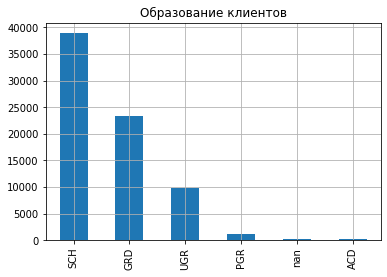

In [1985]:
data_train['education'].astype('str').value_counts().plot(kind='bar', grid=True, title= 'Образование клиентов')

Мы видим, что самым популярным значением в этом столбце является школьное образование. Но, поскольку людей с высшим образованием тоже много, предположем, что люди с более высоким уровнем дохода имеют высшее образование.
Создадим фунцию, которая в пропусках людям с уровнем дохода высшим чем третий квантиль присваивает высшее образование, остальным школьное. Скорее всего это не повлияет на работу модэли, но является отличным поводом потренироваться решать подобные задачи.


In [1986]:
from functools import partial

def fill_edu(quan75, row):
    edu=row['education']
    if type(edu) is not str:
        if row['income'] > quan75:
            return 'GRD'
        else:
            return 'SCH'
        
    else:
        return edu
    


In [1987]:
data_train['education']=data_train.apply(partial(fill_edu, data_train['income'].quantile(0.75)), axis=1)

In [1988]:
data_test['education']=data_test.apply(partial(fill_edu, data_test['income'].quantile(0.75)), axis=1)

In [1989]:
data_train.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
timedelta           0
dtype: int64

Сгруппируем данные разных типов

In [1990]:
bin_cols=['sex','car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
cat_cols=['education', 'home_address', 'work_address'] # категориальные
num_cols=['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'timedelta'] # числовые
time_cols = ['app_date'] # временнЫе

In [1991]:
def range_outliers(x):
    xmedian=x.median()
    xperc25=x.quantile(0.25)
    xperc75=x.quantile(0.75)
    xIQR=xperc75-xperc25
    print('медиана:{},'.format(xmedian),'25% персентиль:{},'.format(xperc25), '75% персентиль:{},'.format(xperc75), 'IQR:{},'.format(xIQR), 'границы выбросов: [{f},{l}]'.format(f=xperc25-1.5*xIQR, l=xperc75+1.5*xIQR))

Посмотрим на распределение числовых признаков:

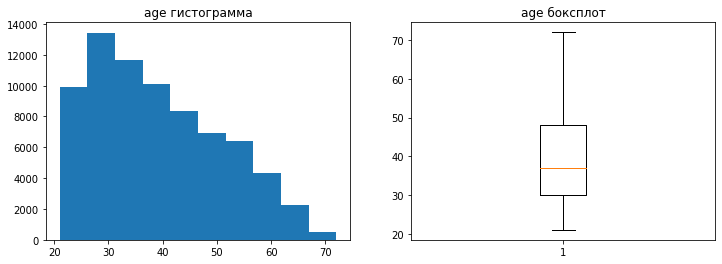

медиана:37.0, 25% персентиль:30.0, 75% персентиль:48.0, IQR:18.0, границы выбросов: [3.0,75.0]


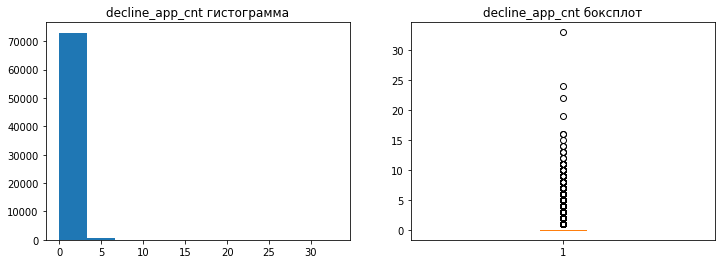

медиана:0.0, 25% персентиль:0.0, 75% персентиль:0.0, IQR:0.0, границы выбросов: [0.0,0.0]


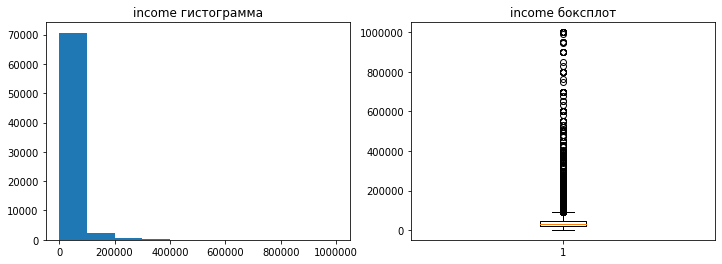

медиана:30000.0, 25% персентиль:20000.0, 75% персентиль:48000.0, IQR:28000.0, границы выбросов: [-22000.0,90000.0]


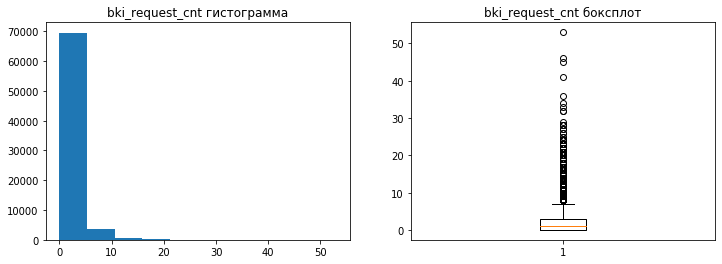

медиана:1.0, 25% персентиль:0.0, 75% персентиль:3.0, IQR:3.0, границы выбросов: [-4.5,7.5]


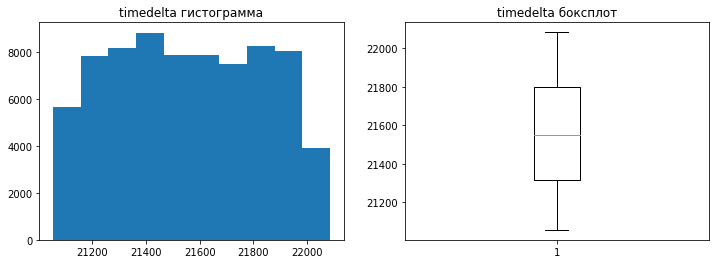

медиана:21548.16, 25% персентиль:21314.88, 75% персентиль:21798.72, IQR:483.84000000000015, границы выбросов: [20589.120000000003,22524.480000000003]


In [1992]:
for i in num_cols:
    
    fig,axes=plt.subplots(1,2, figsize=(12,4))
    
    axes[0].hist(data_train[i])
    axes[0].set_title(i+ ' гистограмма')
    axes[1].boxplot(data_train[i])
    axes[1].set_title(i+ ' боксплот')
    plt.show()
    range_outliers(data_train[i])

После построения гистограмм стало очевидно, что распределения всех числовых переменных, кроме 'timedelta' имеют тяжёлый правый хвост. Для ролучения более равномерного распределения логарифмируем признаки. И посмотрим как изменятся графики 

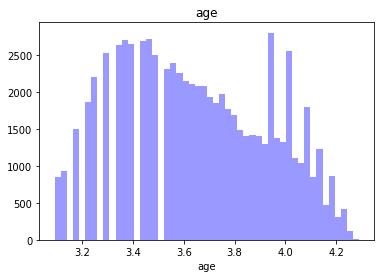

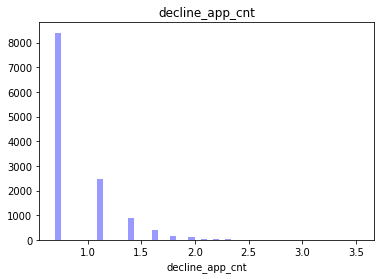

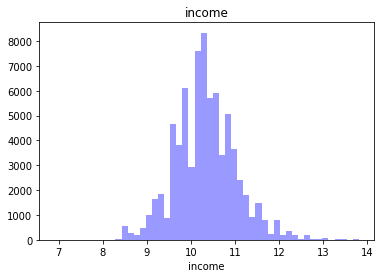

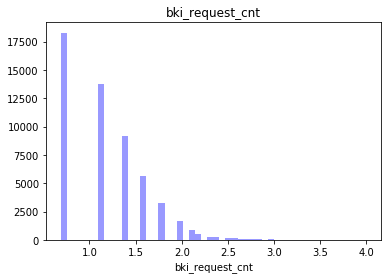

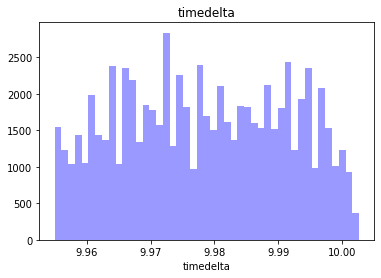

In [1993]:
for i in num_cols:
    data_train[i] = np.log(data_train[i] + 1)
    plt.figure()
    sns.distplot(data_train[i][data_train[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

In [1994]:
data_train.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta
0,25905,2014-02-01,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,N,0,9.990445
1,63161,2014-03-12,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,N,0,9.974879
2,25887,2014-02-01,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,Y,0,9.990445


# Корреляция числовых признаков

In [1995]:
correlation=data_train[num_cols].corr()
correlation

,age,decline_app_cnt,income,bki_request_cnt,timedelta
age,1.000000,-0.127734,-0.092586,0.049327,-0.017087
decline_app_cnt,-0.127734,1.000000,-0.013868,0.125163,0.022722
income,-0.092586,-0.013868,1.000000,0.081019,-0.005260
bki_request_cnt,0.049327,0.125163,0.081019,1.000000,0.009672
timedelta,-0.017087,0.022722,-0.005260,0.009672,1.000000


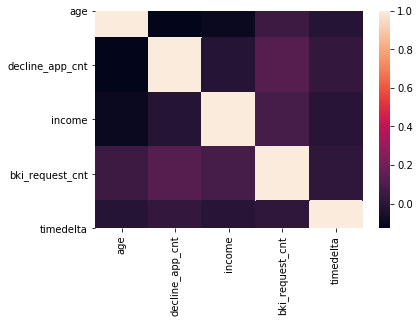

In [1996]:
sns.heatmap(correlation)

Мы видим лишь слабую между 'decline_app_cnt' и 'bki_request_cnt'. Для дальнейшей оценки проверим значимость этих признаков.

# Оценка значимости числовых признаков

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

In [1997]:
f_classif(data_train[num_cols], data_train['default'])

(array([  50.3805738 , 1152.93731744,  214.7905274 ,  457.59176046,
         115.02246571]),
 array([1.27778005e-012, 8.96214000e-251, 1.44923016e-048, 3.26668128e-101,
        8.14370657e-027]))

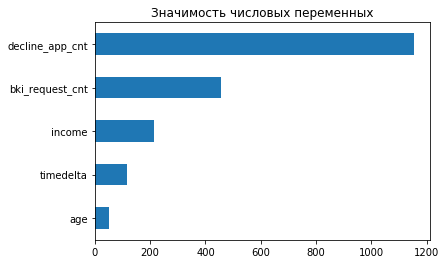

In [1998]:
imp_num = pd.Series(f_classif(data_train[num_cols], data_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

Согласно методу  f_classif, decline_app_cnt - самый значимый признак, в то время, как возраст клиента  имеет наименьшую значимость

# Бинарные признаки

Преобразуем значения бинарных признаков в нули и единицы

In [1999]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data_train[column] = label_encoder.fit_transform(data_train[column])
    data_test[column] = label_encoder.fit_transform(data_test[column])


In [2000]:
print(dict(enumerate(le.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


In [2001]:
data_train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,9.990445
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,9.974879


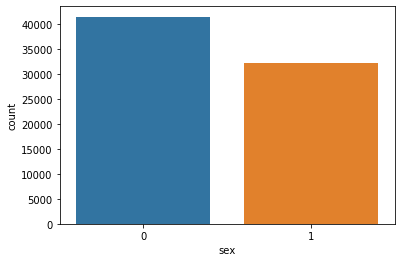

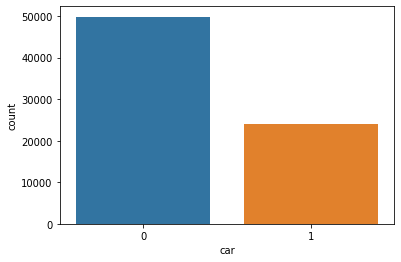

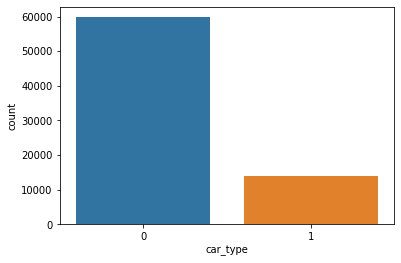

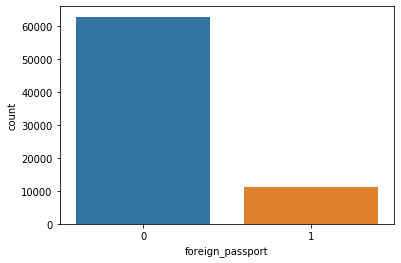

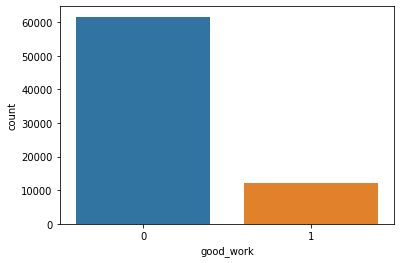

In [2002]:
for column in data_train[bin_cols]:
    bin_cal_val=data_train[column].value_counts()
    #bin_cal_val.plot(kind='bar', title=column)
    sns.countplot(x=data_train[column], data=data_train[bin_cols])
    plt.show()
    #sns.barplot(x=bin_cal_val, data=bin_cal_val)


# Категориальные признаки

In [2003]:
le =preprocessing.LabelEncoder()
le.fit(list(data_train['education'].values))
data_train['education']=le.transform(list(data_train['education'].values))
data_train['education_label']=data_train['education']

data_test['education']=le.transform(list(data_test['education'].values))
data_test['education_label']=data_test['education']

In [2004]:
data_train.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,9.990445,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,9.974879,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0,9.990445,3


In [2005]:
print(dict(enumerate(le.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


Перед тем как преобразовать категориальный признаки в векторы OneHotEncoder, оценим их значимость.

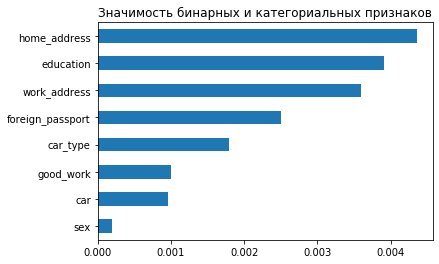

In [2006]:
mutal=pd.Series(mutual_info_classif(data_train[cat_cols+bin_cols], data_train['default'], discrete_features =True), index=cat_cols+bin_cols).sort_values()
mutal.plot(kind = 'barh', title = 'Значимость бинарных и категориальных признаков')

Мы видим, что наибольшее влияние на модель оказывают адресс и образование, в то время, как пол влияет минимально.

In [2007]:
#data=pd.get_dummies(data[cat_cols], prefix=cat_cols, columns=cat_cols)


In [2008]:
X_cat_train = OneHotEncoder(sparse = False).fit_transform(data_train[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(data_test[cat_cols].values)



Стандартизируем числовые переменные

In [2009]:
# Стандартизация числовых переменных

X_num_train =StandardScaler().fit_transform(data_train[num_cols].values)
X_num_test =StandardScaler().fit_transform(data_test[num_cols].values)
X_num_test

array([[-0.88473151, -0.33995109,  0.20922178,  0.42909592, -0.59902814],
       [-0.01615572,  6.00146439, -0.81813846, -0.00630055,  1.18319733],
       [ 0.93927766, -0.33995109, -0.24738277, -0.44169701, -0.63029526],
       ...,
       [-0.71101635,  2.1966151 ,  0.43752406, -0.44169701, -0.84916505],
       [-1.05844667,  0.92833201, -0.24738277, -0.00630055,  1.71473827],
       [-0.10301329, -0.33995109, -0.58983618, -0.00630055, -0.44269258]])

Теперь числовые признаки имеют одинаковый масштаб, что даёт возможность применения метода градиентного спуска

Соеденим подготовленные данные в массивы

In [2010]:
X=np.hstack([X_num_train, data_train[bin_cols].values, X_cat_train])
X_Test = np.hstack([X_num_test, data_test[bin_cols].values, X_cat_test])
y=data_train['default'].values

In [2011]:
X_num_cat=np.hstack([X_num_train, X_cat_train])

Поделим выборку на тренировочную и тестовую 

In [2012]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Применим модель

In [2013]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [2014]:
y_pred_1=model_1.predict(X_test)

In [2015]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_1)))
print('Precision:'+str(precision_score(y_test, y_pred_1)))
print('Recall:'+str(recall_score(y_test, y_pred_1)))
print('f1: ' + str(f1_score(y_test, y_pred_1)))

Accuracy:0.8760840108401085
Precision:0.4375
Recall:0.0038314176245210726
f1: 0.00759631036353771


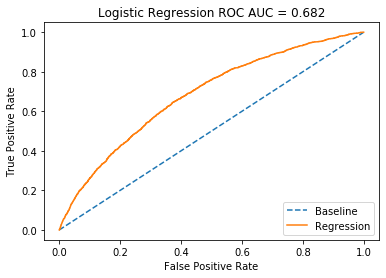

In [2016]:

probs_1 = model_1.predict_proba(X_test)
probs_1 = probs_1[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_1)
roc_auc = roc_auc_score(y_test, probs_1)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Матрица ошибок:

array([[12924,     9],
       [ 1820,     7]], dtype=int64)

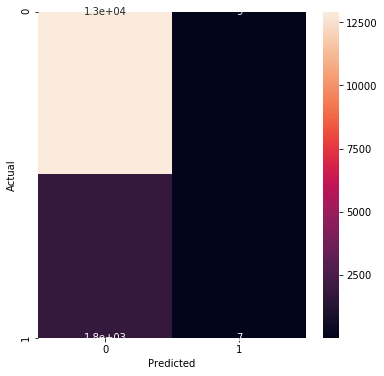

In [2017]:
fig = plt.figure(figsize=(6, 6))
cm1 = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm1, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm

# Займёмся подбором гиперпараметров

In [2018]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

iter_=50
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10, 20, 40 )

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model_0 = LogisticRegression()
model_0.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])


C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trigu\Anaconda3\lib\site-packa

C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this trai

Лучшее Penalty: l2
Лучшее C: 1.0


C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [2019]:
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
# Смотрим лучшие гиперпараметры
model_0 = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model_0.get_params()
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print(f'  {param_name} => {best_parameters[param_name]}')

# Предсказываем
y_pred_prob = model_0.predict_proba(X_test)[:,1]
y_pred = model_0.predict(X_test)

Лучшие значения параметров:
  C => 1.0
  class_weight => None
  dual => False
  fit_intercept => True
  intercept_scaling => 1
  l1_ratio => None
  max_iter => 100
  multi_class => auto
  n_jobs => None
  penalty => l2
  random_state => None
  solver => lbfgs
  tol => 0.0001
  verbose => 0
  warm_start => False


C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [2020]:
model_2 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2', class_weight =None,
                           dual = False, fit_intercept =True, intercept_scaling = 1,
                          l1_ratio = None, max_iter = 1000,  n_jobs = None, tol = 0.0001, verbose = 0,warm_start = False,)

model_2.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [2021]:
y_pred_2=model_2.predict(X_test)

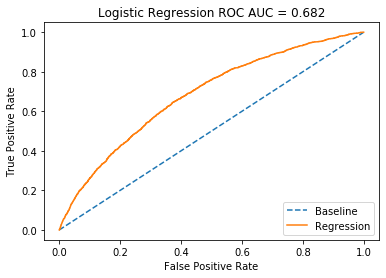

In [2022]:
probs_2 = model_2.predict_proba(X_test)
probs_2 = probs_2[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_2)
roc_auc = roc_auc_score(y_test, probs_2)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [2023]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_2)))
print('Precision:'+str(precision_score(y_test, y_pred_2)))
print('Recall:'+str(recall_score(y_test, y_pred_2)))
print('f1: ' + str(f1_score(y_test, y_pred_2)))

Accuracy:0.8760840108401085
Precision:0.4375
Recall:0.0038314176245210726
f1: 0.00759631036353771


array([[12924,     9],
       [ 1820,     7]], dtype=int64)

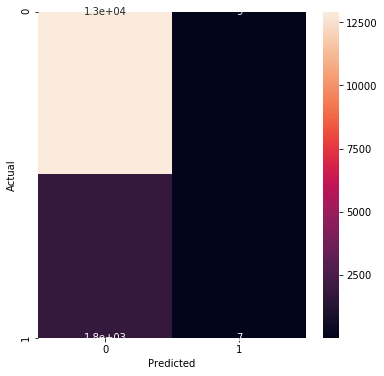

In [2024]:
fig = plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm

Подстановка гиперпараметров не смогла улучшить ситуацию

Возможно, проблемой является несбалансированность выборки по целевой переменной.

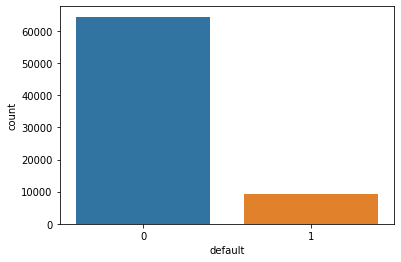

In [2025]:
sns.countplot(x=data_train['default'], data=data_train)

Попробуем для тренировочной выборки сократить количество недефолтных клиентов

In [2026]:
data_reduced_def_0=data_train[:30000][(data_train['default']==0)]
data_reduced_def_0.head(3)


C:\Users\trigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,9.990445,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,9.974879,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0,9.990445,3


In [2027]:
data_reduced_def_1=data_train[(data_train['default']==1)]
data_reduced_def_1.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta,education_label
18,26038,2014-02-02,1,0,3.610918,0,0,0.0,0,-1.971907,...,40,1,3,11.002117,4,1,0,1,9.990049,1
23,51615,2014-02-28,3,1,3.332205,1,1,0.0,0,-2.178540,...,50,2,3,10.915107,4,3,0,1,9.979695,3
24,35287,2014-02-11,3,0,3.295837,0,0,0.0,0,-1.436580,...,60,1,2,10.165890,1,2,0,1,9.986477,3


In [2028]:
data_reduced=data_reduced_def_0.append(data_reduced_def_1)
data_reduced.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,9.990445,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,9.974879,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0,9.990445,3


таким образом мы сократили выборку, но сделали ее более сбалансированной по целевой переменной.

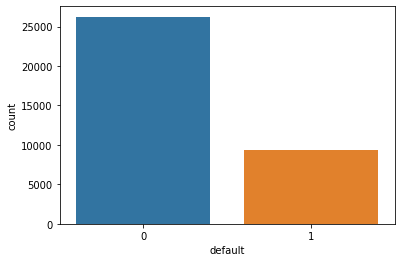

In [2030]:
sns.countplot(x=data_reduced['default'], data=data_reduced)  


In [2031]:

#data_reduced=data_reduced.drop(['age', 'sex', 'client_id', 'app_date'], axis=1)


Попробуем избавиться от выбросов для некоторых числовых признаков

In [2032]:
range_outliers(data_reduced['income'])

медиана:10.308985993422082, 25% персентиль:9.90353755128617, 75% персентиль:10.714439990727769, IQR:0.8109024394415982, границы выбросов: [8.687183892123773,11.930793649890166]


In [2033]:

#range_outliers(data_reduced['bki_request_cnt'])

In [2034]:
#data_reduced=data_reduced[(data_reduced['income']<11.93)& (data_reduced['bki_request_cnt']<3.46)]
#data_reduced.head(3)

In [2035]:
#bin_cols=['car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
#cat_cols=['education', 'home_address', 'work_address'] # категориальные
#num_cols=[ 'decline_app_cnt', 'income', 'bki_request_cnt', 'timedelta'] # числовые
#time_cols = ['app_date'] # временнЫе

In [2036]:
for column in bin_cols:
    data_reduced[column] = label_encoder.fit_transform(data_reduced[column])

In [2037]:
for column in num_cols:
    data_reduced[column] = np.log(data_reduced[column] + 1)
data_reduced.head(3)   

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta,education_label
0,25905,2014-02-01,3,1,1.637663,1,1,0.000000,0,-2.008753,...,50,1,2,2.379378,4,1,0,0,2.397026,3
1,63161,2014-03-12,3,0,1.628131,0,0,0.000000,0,-1.532276,...,50,2,3,2.384372,4,1,0,0,2.395609,3
2,25887,2014-02-01,3,1,1.448822,1,0,0.741276,0,-1.408142,...,80,1,2,2.425598,1,4,1,0,2.397026,3


In [2038]:
X_cat_reduced = OneHotEncoder(sparse = False).fit_transform(data_reduced[cat_cols].values)

In [2039]:
X_num_reduced =StandardScaler().fit_transform(data_reduced[num_cols].values)

In [2040]:
X_num_reduced

array([[ 1.66681227e+00, -4.61961292e-01, -7.61432776e-01,
        -1.26565631e-01,  9.25566795e-01],
       [ 1.51131295e+00, -4.61961292e-01, -6.79177776e-01,
         7.81050973e-01, -2.91340236e-01],
       [-1.41390014e+00,  2.43226918e+00, -2.03787661e-04,
        -1.26565631e-01,  9.25566795e-01],
       ...,
       [ 4.07988106e-01, -4.61961292e-01,  7.27402621e-01,
         7.81050973e-01, -4.48858845e-01],
       [ 1.04649579e+00, -4.61961292e-01, -1.04187312e+00,
         1.01749009e+00,  4.28820479e-01],
       [-8.74656281e-01, -4.61961292e-01, -1.26537760e+00,
         7.81050973e-01,  1.78666547e+00]])

In [2041]:
X_reduced=np.hstack([X_num_reduced, data_reduced[bin_cols].values, X_cat_reduced])


y_reduced=data_reduced['default'].values

In [2042]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_SEED)

In [2043]:
model_3 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2', class_weight =None,
                           dual = False, fit_intercept =True, intercept_scaling = 1,
                          l1_ratio = None, max_iter = 1000,  n_jobs = None, tol = 0.0001, verbose = 0,warm_start = False,)

model_3.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [2044]:
y_pred_reduced=model_3.predict(X_test)

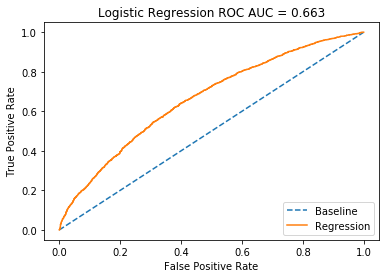

In [2045]:
probs_3 = model_3.predict_proba(X_test)
probs_3 = probs_3[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_3)
roc_auc = roc_auc_score(y_test, probs_3)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [2046]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_reduced)))
print('Precision:'+str(precision_score(y_test, y_pred_reduced)))
print('Recall:'+str(recall_score(y_test, y_pred_reduced)))
print('f1: ' + str(f1_score(y_test, y_pred_reduced)))

Accuracy:0.743719298245614
Precision:0.5647668393782384
Recall:0.1162046908315565
f1: 0.19274977895667553


array([[12924,     9],
       [ 1820,     7]], dtype=int64)

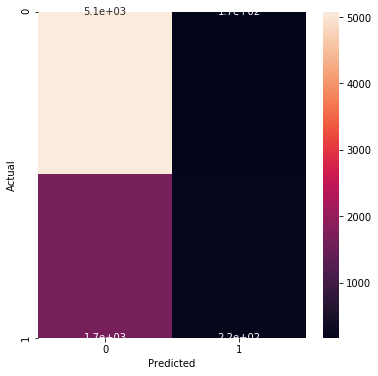

In [2047]:
fig = plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(y_test, y_pred_reduced)
sns.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm

В результате уменьшения выборки с целью её сбалансирования наша f1-score существенно увеличился, но площать под кривой ROC AUC уменшилась. Таким образом мы не улучшили результат

In [2050]:
y_pred_prob = model_3.predict_proba(X_Test)[:,1]


submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [2049]:
#submission_pred_prob = model_3.predict_proba(X_Test)[:,1]
#submission_predict = model_3.predict(X_Test)

#submission = pd.DataFrame({'client_id': data_test['client_id'].values, 
                            #'default': submission_pred_prob})
#submission.to_csv('submission.csv', index=False)

#submission

IndentationError: unexpected indent (<ipython-input-2049-0129a4c9359c>, line 5)